In [1]:
import itertools
from functools import reduce
import argparse
import os
import sys
import numpy as np
from os import mkdir
import torch
from tqdm import tqdm
from PIL import Image
import pandas as pd
import seaborn as sns
from torch.backends import cudnn
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from easydict import EasyDict
import torchvision.transforms.functional as F
from scipy.spatial import distance

from config import cfg
from data import make_data_loader
from engine.inference import inference
from modeling import build_model
from utils.logger import setup_logger
from utils.image import read_im, save_im, make_im_grid, add_border

In [2]:
class BaseLine:

    def __init__(self):
        self.cfg = self.over_cfg(cfg)
        self.num_gpus = int(os.environ["WORLD_SIZE"]) if "WORLD_SIZE" in os.environ else 1
        self.output_dir = self.create_out_dir()
        self.create_log()
        self.init_device()
        self.display_cfg()
        self.create_model_and_loader()
        self.get_default_device()

    ##################################
    # 配置
    ##################################
    def over_cfg(self, cfg):
        # 自定义覆盖
        cfg.config_file = 'configs/softmax_triplet_with_center.yml'
        if cfg.config_file:
            cfg.merge_from_file(cfg.config_file)
        # 使用yml覆盖
        cfg.MODEL.DEVICE_ID = '0'
        cfg.DATASETS.NAMES = 'market1501'
        assert cfg.DATASETS.NAMES in ['cuhk03', 'msmt17', 'dukemtmc', 'market1501']
        cfg.DATASETS.ROOT_DIR = 'data'
        cfg.MODEL.PRETRAIN_CHOICE = 'self'
        cfg.TEST.WEIGHT = 'model/market_resnet50_model_120_rank1_945.pth'
        cfg.freeze()
        return cfg

    def create_out_dir(self):
        self.output_dir = cfg.OUTPUT_DIR
        if self.output_dir and not os.path.exists(self.output_dir):
            mkdir(self.output_dir)

    def create_log(self):
        self.logger = setup_logger("reid_baseline", self.output_dir, 0)
        self.logger.info("Using {} GPUS".format(self.num_gpus))
        self.logger.info(cfg)

    def init_device(self):
        if cfg.MODEL.DEVICE == "cuda":
            os.environ['CUDA_VISIBLE_DEVICES'] = cfg.MODEL.DEVICE_ID
        cudnn.benchmark = True

    def display_cfg(self):
        if cfg.config_file:
            self.logger.info("Loaded configuration file {}".format(cfg.config_file))
            with open(cfg.config_file, 'r') as cf:
                config_str = "\n" + cf.read()
                self.logger.info(config_str)
        self.logger.info("Running with config:\n{}".format(cfg))

    def get_default_device(self):
        """Get default device for `*.to(device)`."""
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ##################################
    # 构造model和dataloader
    ##################################
    def create_model_and_loader(self):
        self.train_loader, self.val_loader, num_query, num_classes = make_data_loader(cfg)
        self.model = build_model(cfg, num_classes)
        self.model.load_param(cfg.TEST.WEIGHT)
        self.model.cuda()
        # print(self.model)

    ##################################
    # infer
    ##################################
    def infer_one_im(self, im=None, im_path=None):
        dic = {'im_path': im_path}
        if im is None:
            dic['im'] = Image.open(im_path).convert("RGB")
            dic['im'] = np.array(dic['im'])

        # 添加bench维度
        dic['im_path'] = [dic['im_path']]
        # 图片读取后, 转化成tensor, 转换通道, 设置GPU格式
        dic['im'] = torch.from_numpy(dic['im']).float().unsqueeze(0).permute(0, 3, 1, 2).to(self.device)
        dic['im'].detype = torch
        dic = self.extract_batch_feat(self.model, dic)
        return dic

    def infer_im_list(self, im_paths_list=None, ims_path=None):
        dict_list = []
        if ims_path and not im_paths_list:
            im_paths_list = self.get_img_list(ims_path)

        for im_path in tqdm(im_paths_list, desc='Extract Feature', miniters=20, ncols=120, unit=' images'):
            feat_dict = self.infer_one_im(im_path=im_path)
            dict_list.append(feat_dict)
        ret_dict = self.concat_dict_list(dict_list)
        return ret_dict

    def extract_batch_feat(self, model, in_dict):
        model.eval()
        with torch.no_grad():
            # in_dict = self.recursive_to_device(in_dict, cfg.device)
            out = model(in_dict['im'])
            ret_dict = {
                'im_path': in_dict['im_path'],
                'feat': out,
            }
        return ret_dict

    ##################################
    # 计算距离
    ##################################
    def calculate_dist(self, array1, array2, dist_type='cosine', cos_to_normalize=True):
        if dist_type == 'cosine':
            if cos_to_normalize:
                array1 = self.normalize(array1, axis=1)
                array2 = self.normalize(array2, axis=1)
            dist = - np.matmul(array1, array2.T)
            # Turn distance into positive value
            dist += 1
        elif dist_type == 'euclidean':
            square1 = np.sum(np.square(array1), axis=1)[..., np.newaxis]
            square2 = np.sum(np.square(array2), axis=1)[np.newaxis, ...]
            dist = - 2 * np.matmul(array1, array2.T) + square1 + square2
            dist[dist < 0] = 0
            np.sqrt(dist, out=dist)
        else:
            raise NotImplementedError
        return dist

    def calculate_rank_gt(self, dis_mat):
        rank_list = []
        same_id = []

        for i in range(7):
            dist_vect = dis_mat.iloc[i].sort_values()[:7]
            # 行标签名字
            dist_vect_name = dist_vect.name
            # 列标签列表
            sort_inds = list(dist_vect.index)
            temp = []
            id_q = self.parse_filename(dist_vect_name)[1].split('-')[0]

            for j in range(7):
                id_g = self.parse_filename(sort_inds[j])[1].split('-')[0]
                temp.append(id_q == id_g)
            rank_list.append(sort_inds)
            same_id.append(temp)
        return rank_list, same_id

    ##################################
    # functools
    ##################################
    @staticmethod
    def concat_dict_list(dict_list):
        for key in dict_list[0].keys():
            if key == 'feat':
                feat_list = [dic[key] for dic in dict_list]
                # 为什么stack多出dim1??? 删掉
                feats = torch.stack(feat_list, dim=0).unbind(dim=1)[0]
            elif key == 'im_path':
                func = lambda x, y : x+y
                img_list = [dic[key] for dic in dict_list]
                im_paths = list(reduce(func, img_list))
        ret_dict = {
            'feats' : feats,
            'im_paths' : im_paths
        }
        return ret_dict

    @staticmethod
    def get_img_list(path):
        is_image_file = lambda x: os.path.splitext(x)[1] in ['.jpg']
        return [os.path.join(path, x) for x in os.listdir(path) if is_image_file(x)]

    @staticmethod
    def normalize(np_array, order=2, axis=0):
        if isinstance(np_array[0], torch.Tensor):
            np_array = np.array(list(map(lambda x: x.cpu().numpy(), np_array)))
        """Normalize a N-D numpy array along the specified axis."""
        norm = np.linalg.norm(np_array, ord=order, axis=axis, keepdims=True)
        return np_array / (norm + np.finfo(np.float32).eps)

    @staticmethod
    def parse_filename(filename):
        filepath, tempfilename = os.path.split(filename)
        shotname, extension = os.path.splitext(tempfilename)
        return filepath, shotname, extension

In [3]:
def cover_tensor_numpy(obj):
    if isinstance(obj[0], torch.Tensor):
        obj = np.array(list(map(lambda x: x.cpu().numpy(), obj)))
    return obj

def draw_dist(mat):
    f, ax = plt.subplots(figsize=(13, 13), nrows=1)
    sns.heatmap(mat, linewidths=0.08, ax=ax, vmax=0.04, cmap='rainbow')
    plt.show()
    
def save_rank_list_to_im(rank_list, q_im_path, g_im_paths, save_path, same_id=None, resize_h_w=(128, 64)):
    ims = [read_im(q_im_path, convert_rgb=True, resize_h_w=resize_h_w, transpose=True)]
    for i, ind in enumerate(rank_list):
        im = read_im(g_im_paths[ind], convert_rgb=True, resize_h_w=resize_h_w, transpose=True)
        if same_id is not None:
            # 正确绿框, 不准确红框
            color = np.array([0, 255, 0]) if same_id[i] else np.array([255, 0, 0])
            im = add_border(im, 3, color)
        ims.append(im)
    im = make_im_grid(ims, 1, len(rank_list) + 1, 8, 255)
    save_im(im, save_path, transpose=True)
    
def get_rank_imgs(rank_list, q_im_path, same_id=None, resize_h_w=(128, 64)):
    ims = [read_im(q_im_path, convert_rgb=True, resize_h_w=resize_h_w, transpose=True)]
    for i, ind in enumerate(rank_list):
        im = read_im(ind, convert_rgb=True, resize_h_w=resize_h_w, transpose=True)
        if same_id is not None:
            # Add green boundary to true positive, red to false positive
            color = np.array([0, 255, 0]) if same_id[i] else np.array([255, 0, 0])
            im = add_border(im, 3, color)
        ims.append(im)
    im = make_im_grid(ims, 1, len(rank_list) + 1, 8, 255)
    return im
    
def file_name(file_dir):   
    L=[]   
    for root, dirs, files in os.walk(file_dir):  
        for file in files:  
            L.append(os.path.join(root, file))  
    return L  

In [4]:
baseline = BaseLine()

2019-04-25 16:08:47,394 reid_baseline INFO: Using 1 GPUS
2019-04-25 16:08:47,395 reid_baseline INFO: DATALOADER:
  NUM_INSTANCE: 4
  NUM_WORKERS: 8
  SAMPLER: softmax_triplet
DATASETS:
  NAMES: market1501
  ROOT_DIR: data
INPUT:
  PADDING: 10
  PIXEL_MEAN: [0.485, 0.456, 0.406]
  PIXEL_STD: [0.229, 0.224, 0.225]
  PROB: 0.5
  RE_PROB: 0.5
  SIZE_TEST: [256, 128]
  SIZE_TRAIN: [256, 128]
MODEL:
  DEVICE: cuda
  DEVICE_ID: 0
  IF_LABELSMOOTH: on
  IF_WITH_CENTER: yes
  LAST_STRIDE: 1
  METRIC_LOSS_TYPE: triplet_center
  NAME: resnet50
  NECK: bnneck
  PRETRAIN_CHOICE: self
  PRETRAIN_PATH: model/resnet50-19c8e357.pth
OUTPUT_DIR: reid_baseline_review/market1501/Experiment-all-tricks-tri_center-256x128-bs16x4-warmup10-erase0_5-labelsmooth_on-laststride1-bnneck_on-triplet_centerloss0_0005
SOLVER:
  BASE_LR: 0.00035
  BIAS_LR_FACTOR: 1
  CENTER_LOSS_WEIGHT: 0.0005
  CENTER_LR: 0.5
  CHECKPOINT_PERIOD: 40
  CLUSTER_MARGIN: 0.3
  EVAL_PERIOD: 40
  GAMMA: 0.1
  IMS_PER_BATCH: 64
  LOG_PERIOD: 2

# 测试一张图片

In [5]:

result1 = baseline.infer_one_im(im_path='data/market1501/Market-1501-v15.09.15/bounding_box_test/0000_c1s1_000151_01.jpg')
result1

{'feat': tensor([[12.9761, -0.5191, -0.4698,  ..., -1.9369, 13.4632, 17.8024]],
        device='cuda:0'),
 'im_path': ['data/market1501/Market-1501-v15.09.15/bounding_box_test/0000_c1s1_000151_01.jpg']}

# 测试图片列表

In [6]:
# 测试图片列表
query_result = baseline.infer_im_list(ims_path='data/resize')
query_feat, query_paths = query_result.values()
query_feat = cover_tensor_numpy(query_feat)

Extract Feature: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.06 images/s]


In [7]:
dis_mat = baseline.calculate_dist(query_feat, query_feat)
dis_mat = pd.DataFrame(dis_mat, index=query_result['im_paths'], columns=query_paths)
dis_mat

,data/resize/84.jpg,data/resize/10.jpg,data/resize/11.jpg,data/resize/12.jpg,data/resize/141.jpg,data/resize/142.jpg,data/resize/143.jpg,data/resize/144.jpg,data/resize/145.jpg,data/resize/146.jpg,...,data/resize/87.jpg,data/resize/88.jpg,data/resize/91.jpg,data/resize/92.jpg,data/resize/93.jpg,data/resize/94.jpg,data/resize/95.jpg,data/resize/96.jpg,data/resize/97.jpg,data/resize/98.jpg
data/resize/84.jpg,-1.192093e-07,0.005331,1.846194e-02,2.070194e-02,9.512305e-04,1.999497e-03,1.089156e-02,8.587837e-04,4.582644e-03,4.713655e-03,...,1.325196e-02,1.397097e-02,3.231227e-03,0.016334,0.008790,0.001510,0.003378,0.009844,1.964718e-02,1.292264e-02
data/resize/10.jpg,5.330563e-03,0.000000,1.230294e-02,1.560694e-02,5.703390e-03,3.608227e-03,2.441818e-02,6.575704e-03,4.338980e-03,3.695250e-03,...,7.968783e-03,4.994392e-03,7.049620e-03,0.009500,0.007423,0.006889,0.003697,0.005838,1.232356e-02,1.842099e-02
data/resize/11.jpg,1.846194e-02,0.012303,1.788139e-07,2.651930e-03,1.752824e-02,9.784043e-03,5.300230e-02,2.216750e-02,7.337511e-03,7.164717e-03,...,5.003333e-03,7.888675e-03,1.379013e-02,0.001172,0.004110,0.020404,0.009523,0.002611,2.299309e-03,5.115497e-02
data/resize/12.jpg,2.070194e-02,0.015607,2.651930e-03,1.192093e-07,2.129602e-02,1.304609e-02,5.581295e-02,2.582711e-02,1.048797e-02,1.098108e-02,...,5.409956e-03,8.759975e-03,1.696312e-02,0.003554,0.006847,0.024624,0.011745,0.004996,4.596353e-03,5.240953e-02
data/resize/141.jpg,9.512305e-04,0.005703,1.752824e-02,2.129602e-02,-2.384186e-07,1.468778e-03,1.150966e-02,8.736849e-04,4.601181e-03,4.059553e-03,...,1.405251e-02,1.527166e-02,2.940178e-03,0.015695,0.007475,0.000626,0.004222,0.009350,1.906955e-02,1.552463e-02
data/resize/142.jpg,1.999497e-03,0.003608,9.784043e-03,1.304609e-02,1.468778e-03,1.192093e-07,1.947045e-02,3.060102e-03,2.059579e-03,1.217961e-03,...,7.889986e-03,9.529352e-03,2.174139e-03,0.008299,0.003328,0.002586,0.001656,0.003975,1.070988e-02,2.133316e-02
data/resize/143.jpg,1.089156e-02,0.024418,5.300230e-02,5.581295e-02,1.150966e-02,1.947045e-02,1.788139e-07,8.278966e-03,2.539933e-02,2.596802e-02,...,4.320651e-02,4.279733e-02,1.932585e-02,0.049520,0.034101,0.009867,0.022763,0.037618,5.502170e-02,8.265436e-03
data/resize/144.jpg,8.587837e-04,0.006576,2.216750e-02,2.582711e-02,8.736849e-04,3.060102e-03,8.278966e-03,-1.192093e-07,6.312847e-03,5.980849e-03,...,1.738214e-02,1.784712e-02,4.279554e-03,0.019961,0.010957,0.000679,0.005380,0.012545,2.345860e-02,1.250255e-02
data/resize/145.jpg,4.582644e-03,0.004339,7.337511e-03,1.048797e-02,4.601181e-03,2.059579e-03,2.539933e-02,6.312847e-03,-1.192093e-07,2.041638e-03,...,6.180286e-03,7.443428e-03,5.269289e-03,0.006793,0.004723,0.006294,0.002279,0.004066,1.046950e-02,2.473772e-02
data/resize/146.jpg,4.713655e-03,0.003695,7.164717e-03,1.098108e-02,4.059553e-03,1.217961e-03,2.596802e-02,5.980849e-03,2.041638e-03,-1.192093e-07,...,6.192684e-03,8.265972e-03,2.950490e-03,0.005457,0.002735,0.005328,0.001770,0.002363,7.379949e-03,2.651584e-02


In [8]:
dis_mat.describe()

,data/resize/84.jpg,data/resize/10.jpg,data/resize/11.jpg,data/resize/12.jpg,data/resize/141.jpg,data/resize/142.jpg,data/resize/143.jpg,data/resize/144.jpg,data/resize/145.jpg,data/resize/146.jpg,...,data/resize/87.jpg,data/resize/88.jpg,data/resize/91.jpg,data/resize/92.jpg,data/resize/93.jpg,data/resize/94.jpg,data/resize/95.jpg,data/resize/96.jpg,data/resize/97.jpg,data/resize/98.jpg
count,5.000000e+01,50.000000,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,...,5.000000e+01,5.000000e+01,5.000000e+01,50.000000,50.000000,50.000000,50.000000,50.000000,5.000000e+01,5.000000e+01
mean,9.947763e-03,0.007803,1.157511e-02,1.362655e-02,1.006599e-02,6.964569e-03,3.168866e-02,1.208356e-02,7.074807e-03,6.849631e-03,...,9.253267e-03,9.706434e-03,1.019336e-02,0.009879,0.008623,0.011721,0.007400,0.007391,1.280070e-02,2.917347e-02
std,7.269801e-03,0.005933,1.358064e-02,1.369877e-02,7.417872e-03,6.214092e-03,1.714014e-02,8.646841e-03,6.804782e-03,6.936246e-03,...,1.020039e-02,9.429912e-03,6.903552e-03,0.012508,0.008820,0.008246,0.006051,0.009455,1.364415e-02,1.486711e-02
min,-1.192093e-07,0.000000,1.788139e-07,1.192093e-07,-2.384186e-07,1.192093e-07,1.788139e-07,-1.192093e-07,-1.192093e-07,-1.192093e-07,...,-2.384186e-07,1.192093e-07,1.788139e-07,0.000000,0.000000,0.000000,0.000000,0.000000,1.192093e-07,1.192093e-07
25%,4.010767e-03,0.004005,3.615320e-03,5.087107e-03,4.100055e-03,2.062321e-03,1.936200e-02,5.408973e-03,3.011361e-03,2.413437e-03,...,3.876165e-03,4.923761e-03,4.344329e-03,0.002928,0.004596,0.005420,0.003527,0.002975,5.291134e-03,1.798308e-02
50%,8.523971e-03,0.005661,7.251114e-03,9.175181e-03,8.289933e-03,4.871756e-03,3.077820e-02,1.066580e-02,5.349457e-03,5.270004e-03,...,5.897999e-03,7.506281e-03,8.996636e-03,0.005548,0.006711,0.009649,0.006080,0.004766,8.227140e-03,2.637693e-02
75%,1.555236e-02,0.009371,1.307410e-02,1.554176e-02,1.566127e-02,9.720370e-03,4.548122e-02,1.885827e-02,7.664829e-03,7.604063e-03,...,9.690478e-03,1.004063e-02,1.438096e-02,0.010710,0.009097,0.018599,0.009119,0.006719,1.427549e-02,3.793927e-02
max,2.707803e-02,0.027668,6.433725e-02,6.483555e-02,2.686161e-02,2.886653e-02,6.686765e-02,3.194290e-02,3.578240e-02,3.542781e-02,...,4.852557e-02,4.313827e-02,3.014654e-02,0.058169,0.046220,0.030180,0.029991,0.046380,6.463021e-02,6.080848e-02


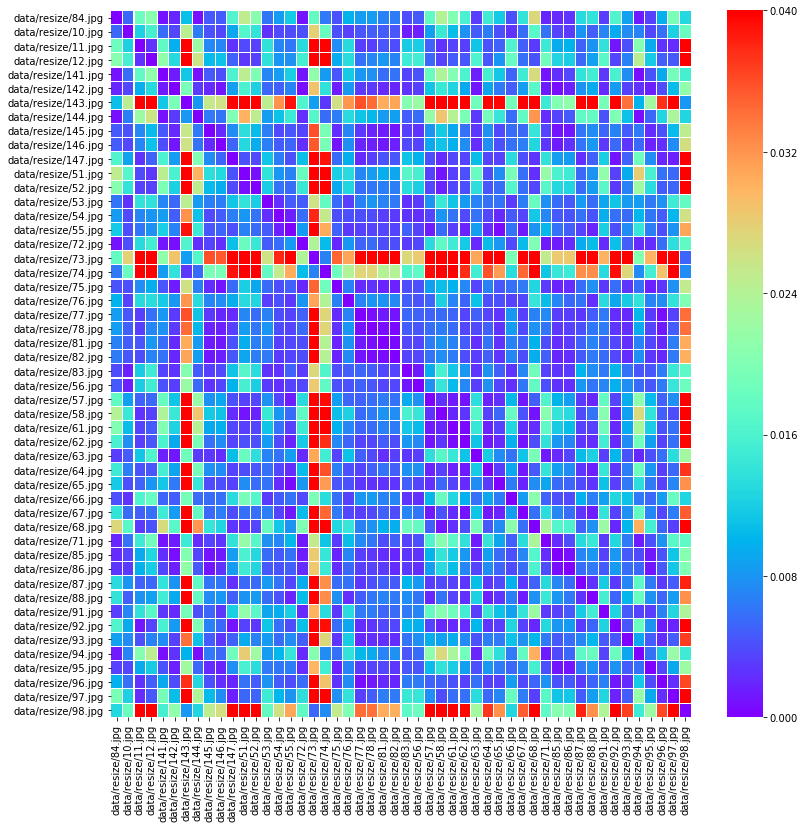

In [9]:
draw_dist(dis_mat)

In [10]:
rank_list, same_id = baseline.calculate_rank_gt(dis_mat)

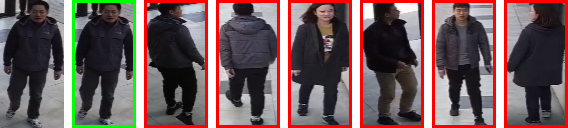

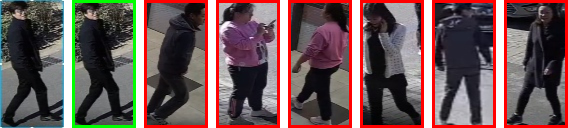

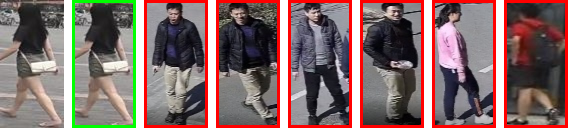

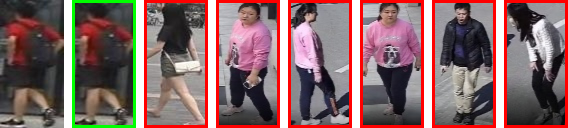

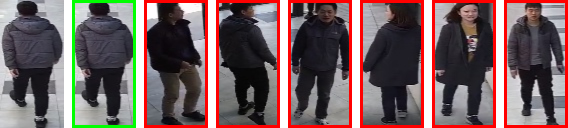

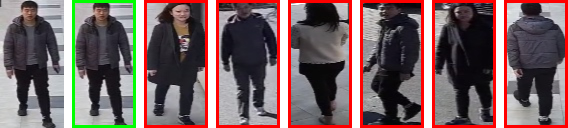

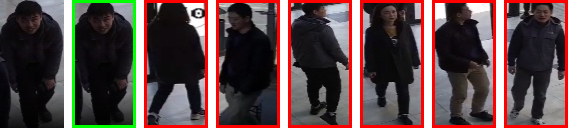

In [11]:
imgs = []
for q_im_path, ranks, ids  in zip(dis_mat.index, rank_list, same_id):
    imgs.append(get_rank_imgs(ranks, q_im_path, same_id=ids))
for image in imgs:
    display( Image.fromarray(image.transpose(1, 2, 0)) )

## 试试sklearn封装的余弦距离

In [12]:
dis_mat_sklearn = 1 - pd.DataFrame(cosine_similarity(query_feat, query_feat), 
                             index=query_result['im_paths'], columns=query_paths)
dis_mat_sklearn

,data/resize/84.jpg,data/resize/10.jpg,data/resize/11.jpg,data/resize/12.jpg,data/resize/141.jpg,data/resize/142.jpg,data/resize/143.jpg,data/resize/144.jpg,data/resize/145.jpg,data/resize/146.jpg,...,data/resize/87.jpg,data/resize/88.jpg,data/resize/91.jpg,data/resize/92.jpg,data/resize/93.jpg,data/resize/94.jpg,data/resize/95.jpg,data/resize/96.jpg,data/resize/97.jpg,data/resize/98.jpg
data/resize/84.jpg,-2.384186e-07,5.330622e-03,1.846218e-02,2.070177e-02,9.511113e-04,1.999557e-03,1.089162e-02,8.586645e-04,0.004583,4.713655e-03,...,1.325178e-02,1.397091e-02,3.231227e-03,1.633346e-02,0.008790,0.001510,0.003378,9.843469e-03,1.964712e-02,1.292276e-02
data/resize/10.jpg,5.330622e-03,2.384186e-07,1.230323e-02,1.560682e-02,5.703449e-03,3.608227e-03,2.441823e-02,6.575644e-03,0.004339,3.695428e-03,...,7.968783e-03,4.994392e-03,7.049620e-03,9.499431e-03,0.007423,0.006889,0.003697,5.838096e-03,1.232362e-02,1.842117e-02
data/resize/11.jpg,1.846218e-02,1.230323e-02,5.364418e-07,2.651989e-03,1.752847e-02,9.784341e-03,5.300248e-02,2.216768e-02,0.007338,7.165015e-03,...,5.003572e-03,7.888913e-03,1.379031e-02,1.172006e-03,0.004110,0.020404,0.009523,2.610743e-03,2.299607e-03,5.115539e-02
data/resize/12.jpg,2.070177e-02,1.560682e-02,2.651989e-03,-1.192093e-07,2.129591e-02,1.304603e-02,5.581284e-02,2.582699e-02,0.010488,1.098096e-02,...,5.409837e-03,8.759975e-03,1.696295e-02,3.553867e-03,0.006847,0.024623,0.011745,4.996002e-03,4.596233e-03,5.240953e-02
data/resize/141.jpg,9.511113e-04,5.703449e-03,1.752847e-02,2.129591e-02,-2.384186e-07,1.468837e-03,1.150960e-02,8.736253e-04,0.004601,4.059613e-03,...,1.405245e-02,1.527166e-02,2.940118e-03,1.569510e-02,0.007475,0.000626,0.004222,9.349585e-03,1.906961e-02,1.552492e-02
data/resize/142.jpg,1.999557e-03,3.608227e-03,9.784341e-03,1.304603e-02,1.468837e-03,1.192093e-07,1.947039e-02,3.060102e-03,0.002060,1.218021e-03,...,7.889986e-03,9.529352e-03,2.174199e-03,8.298635e-03,0.003328,0.002586,0.001656,3.975093e-03,1.070988e-02,2.133334e-02
data/resize/143.jpg,1.089162e-02,2.441823e-02,5.300248e-02,5.581284e-02,1.150960e-02,1.947039e-02,2.384186e-07,8.278966e-03,0.025399,2.596807e-02,...,4.320651e-02,4.279733e-02,1.932579e-02,4.951978e-02,0.034101,0.009867,0.022763,3.761822e-02,5.502170e-02,8.265615e-03
data/resize/144.jpg,8.586645e-04,6.575644e-03,2.216768e-02,2.582699e-02,8.736253e-04,3.060102e-03,8.278966e-03,-2.384186e-07,0.006313,5.980849e-03,...,1.738214e-02,1.784694e-02,4.279494e-03,1.996130e-02,0.010957,0.000679,0.005379,1.254451e-02,2.345860e-02,1.250267e-02
data/resize/145.jpg,4.582644e-03,4.339099e-03,7.337928e-03,1.048797e-02,4.601240e-03,2.059579e-03,2.539939e-02,6.312847e-03,0.000000,2.041757e-03,...,6.180346e-03,7.443488e-03,5.269349e-03,6.792903e-03,0.004723,0.006294,0.002279,4.066050e-03,1.046950e-02,2.473795e-02
data/resize/146.jpg,4.713655e-03,3.695428e-03,7.165015e-03,1.098096e-02,4.059613e-03,1.218021e-03,2.596807e-02,5.980849e-03,0.002042,5.960464e-08,...,6.192923e-03,8.265972e-03,2.950549e-03,5.457282e-03,0.002735,0.005328,0.001770,2.363205e-03,7.380009e-03,2.651602e-02


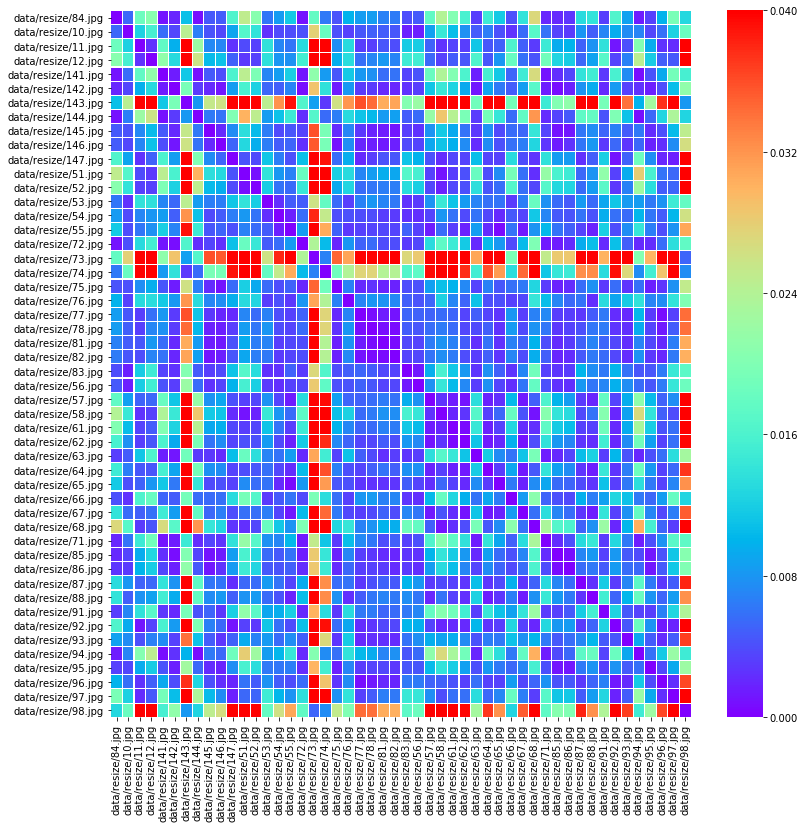

In [13]:
draw_dist(dis_mat_sklearn)

In [14]:
imgs = []
for q_im_path, ranks, ids  in zip(dis_mat_sklearn.index, rank_list, same_id):
    imgs.append(get_rank_imgs(ranks, q_im_path, same_id=ids))

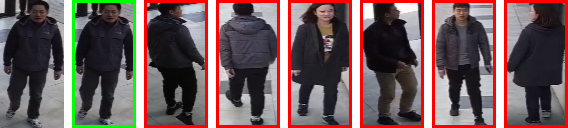

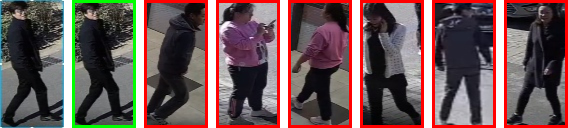

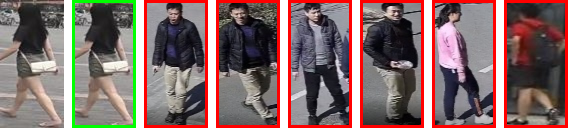

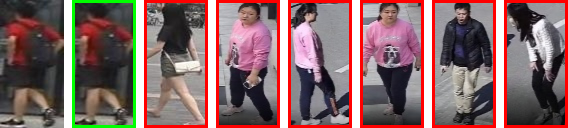

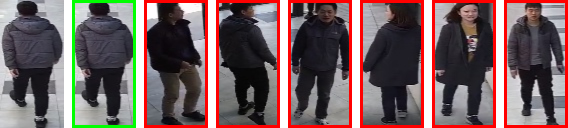

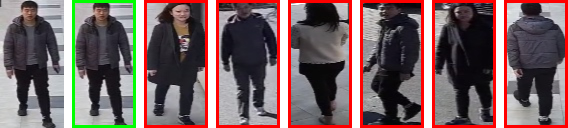

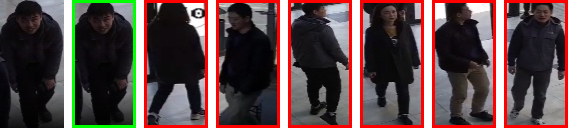

In [15]:
for image in imgs:
    display( Image.fromarray(image.transpose(1, 2, 0)) )